In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [4]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [5]:
original_dim = 28*28
dim = 10000

100%|██████████| 2000/2000 [00:07<00:00, 268.77it/s]


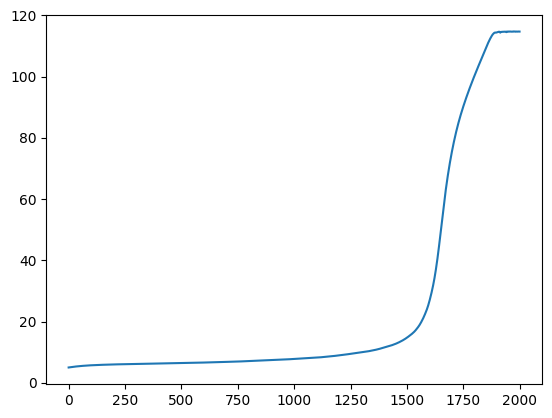

In [8]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 0.9)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 4000/4000 [00:14<00:00, 273.92it/s]


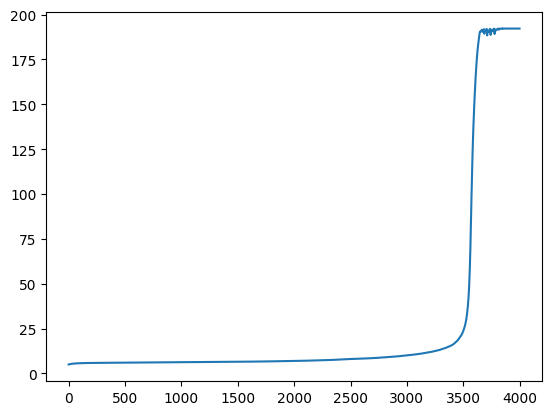

In [10]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 1.5)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=4000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 8000/8000 [00:29<00:00, 274.22it/s]


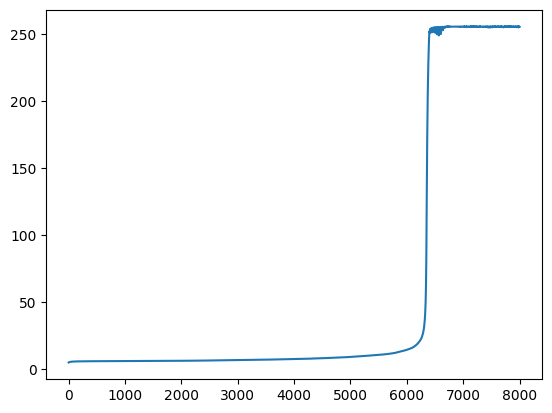

In [12]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 2.)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=8000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 10000/10000 [00:38<00:00, 256.87it/s]


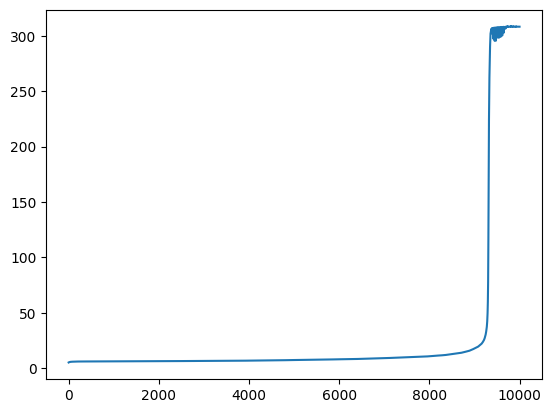

In [18]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 2.42)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=True)
plt.plot(method3_history)
plt.show()

100%|██████████| 10000/10000 [00:36<00:00, 272.57it/s]


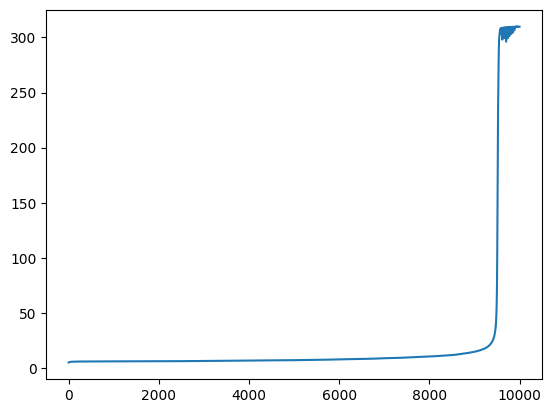

In [20]:
dists = torch.distributions.Normal(0.0, 1)
samples = dists.sample(sample_shape=torch.Size((1, dim, original_dim)))
encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[0] * 2.43)
model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
model.bundling(X_test, y_test) # X_train, y_train
max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=True)
plt.plot(method3_history)
plt.show()

In [8]:
def get_opt_alpha(model: robustness_model.ClassificationModel):
    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False)
    return L3

In [14]:
def overall_robustness_method3(model: robustness_model.ClassificationModel, X):
    
    ep3s = []

    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000, show_pbar=False)

    for x in X:
        ep3 = model.get_eps(x, L3)
        ep3s.append(ep3)
    
    return torch.tensor(ep3s).mean()

In [10]:
def train(sample_size=10, lr=0.001, epochs=50):

    theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs()) # theta = (0, sigma) = (sigma)
    print(theta)
    optimizer = torch.optim.Adam([theta], lr=lr)

    loss_history = []
    theta_history = []
    epsilon_history = []

    with tqdm.tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()

            dists = torch.distributions.Normal(0.0, 1)
            samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
            
            epsilons = []
            for sample in samples:
                M = sample*theta
                encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
                model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
                model.bundling(X_test, y_test) # X_train, y_train

                # epsilon = overall_robustness_method3(model, X_test) # X_train
                # epsilons.append(epsilon)
                
                # Constant Alpha
                # encoder_ = robustness_model.FHRREncoder(original_dim, dim, M=M.detach())
                # model_ = robustness_model.ClassificationModel(encoder_, in_dim=original_dim, dim=dim)
                # model_.bundling(X_test, y_test)
                model_ = model.detach()
                alpha = get_opt_alpha(model_)

                ep3s = torch.stack([model.get_eps(x, alpha) for x in X_test])
                epsilons.append(ep3s.mean())

            epsilons = torch.stack(epsilons)

            # REPARAMETARIZATION TRICK
            loss = -epsilons.mean()
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())
            theta_history.append(theta.item())
            epsilon_history.append(epsilons.mean().item())

            pbar.update(1)
            pbar.set_postfix({
                'Loss': loss.item(),
                'Theta': theta.item(),
                'Epsilon': epsilons.mean().item(),
            })

    return loss_history, theta_history, epsilon_history


trial 0


100%|██████████| 50/50 [2:40:23<00:00, 192.48s/it, Loss=-.112, Theta=0.586, Epsilon=0.112]    


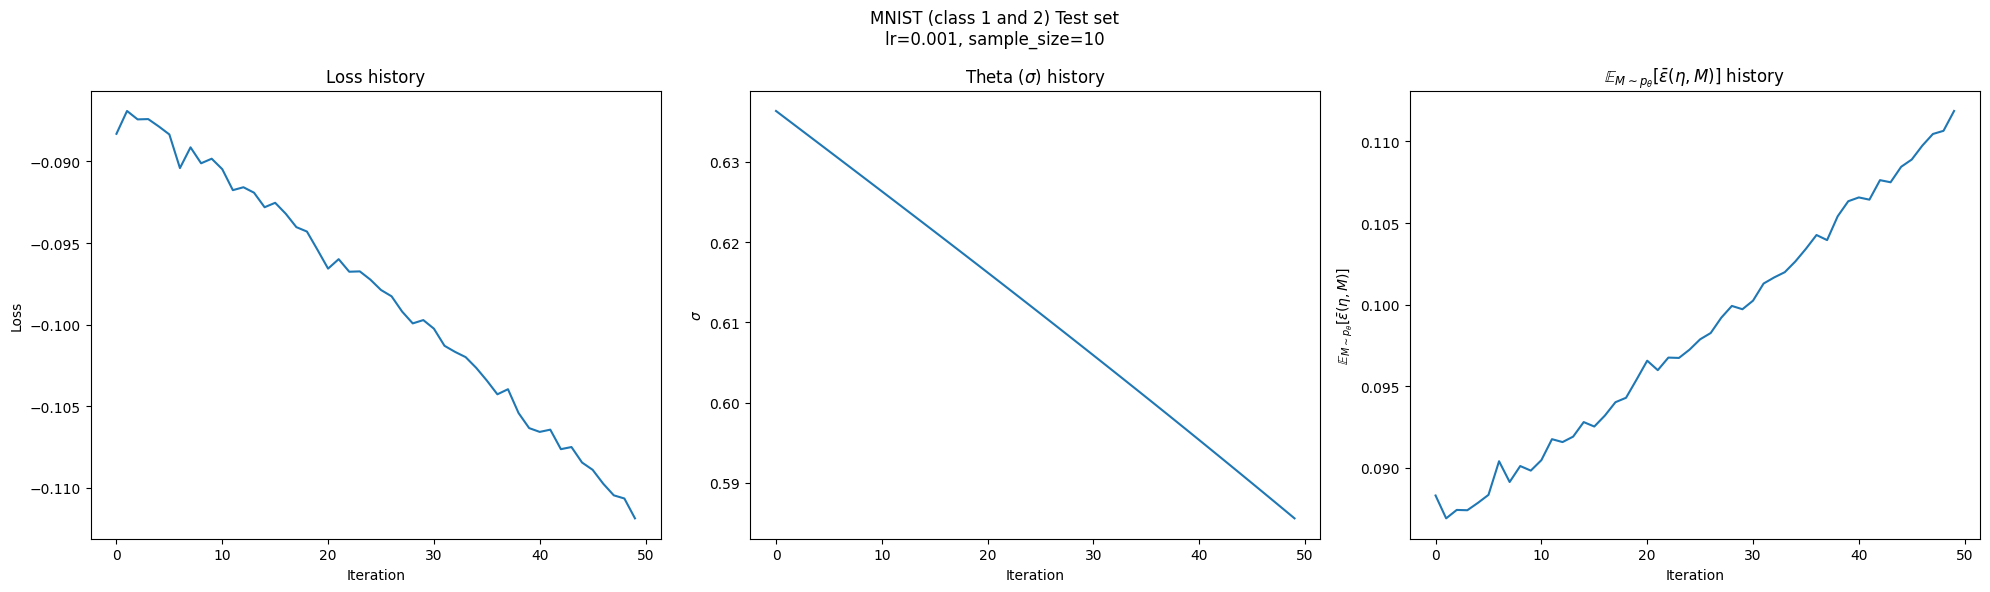

trial 1


100%|██████████| 50/50 [2:26:52<00:00, 176.24s/it, Loss=-.29, Theta=1.34, Epsilon=0.29]    


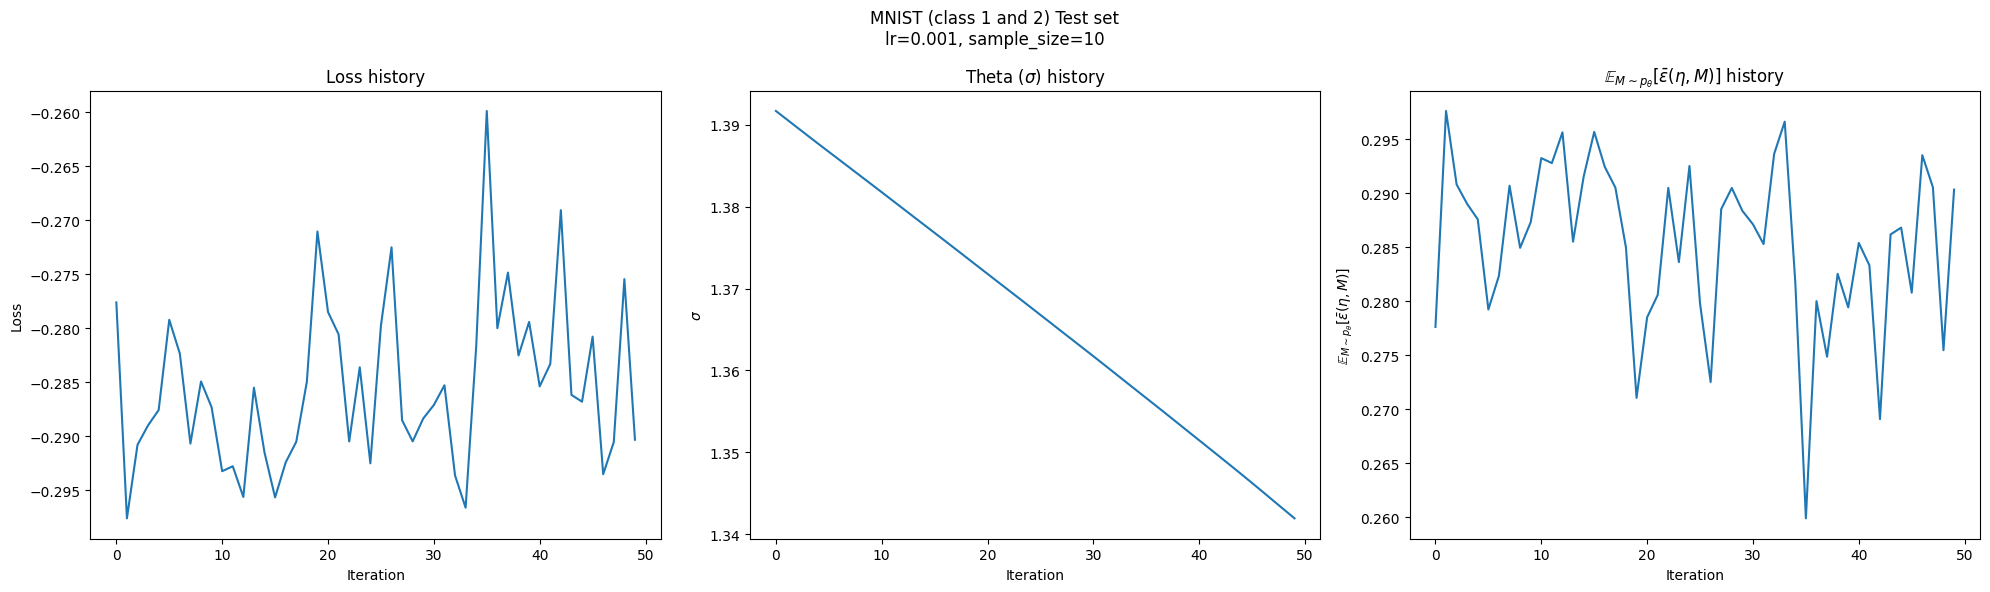

trial 2


 42%|████▏     | 21/50 [1:00:52<1:24:04, 173.95s/it, Loss=-1.57, Theta=0.185, Epsilon=1.57]


KeyboardInterrupt: 

In [9]:
sample_size = 10
lr = 0.001
epochs = 50

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history = train(sample_size=sample_size, lr=lr, epochs=epochs)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

In [ ]:
# trial 0
#  8%|▊         | 4/50 [11:48<2:15:14, 176.40s/it, Loss=-.0874, Theta=0.633, Epsilon=0.0874]
# 16%|█▌        | 8/50 [23:38<2:04:47, 178.28s/it, Loss=-.0891, Theta=0.629, Epsilon=0.0891]
# 22%|██▏       | 11/50 [33:12<2:02:00, 187.71s/it, Loss=-.0905, Theta=0.626, Epsilon=0.0905]
# 30%|███       | 15/50 [45:02<1:44:32, 179.21s/it, Loss=-.0928, Theta=0.622, Epsilon=0.0928]
# 48%|████▊     | 24/50 [1:11:08<1:16:54, 177.49s/it, Loss=-.0967, Theta=0.613, Epsilon=0.0967]
# 60%|██████    | 30/50 [1:28:36<57:13, 171.70s/it, Loss=-.0997, Theta=0.607, Epsilon=0.0997]  
# 76%|███████▌  | 38/50 [2:04:24<44:41, 223.49s/it, Loss=-.104, Theta=0.599, Epsilon=0.104]

# trial 1
#  2%|▏         | 1/50 [02:55<2:22:56, 175.03s/it, Loss=-.278, Theta=1.39, Epsilon=0.278]
#  4%|▍         | 2/50 [05:55<2:22:41, 178.36s/it, Loss=-.298, Theta=1.39, Epsilon=0.298]
# 16%|█▌        | 8/50 [24:12<2:07:03, 181.51s/it, Loss=-.291, Theta=1.38, Epsilon=0.291]
# 22%|██▏       | 11/50 [33:31<1:59:50, 184.37s/it, Loss=-.293, Theta=1.38, Epsilon=0.293]
# 84%|████████▍ | 42/50 [2:03:30<23:18, 174.78s/it, Loss=-.283, Theta=1.35, Epsilon=0.283]

trial 0
Parameter containing:
tensor(1.1499, requires_grad=True)


100%|██████████| 10/10 [1:22:05<00:00, 492.53s/it, Loss=-.0172, Theta=1.14, Epsilon=0.0172]


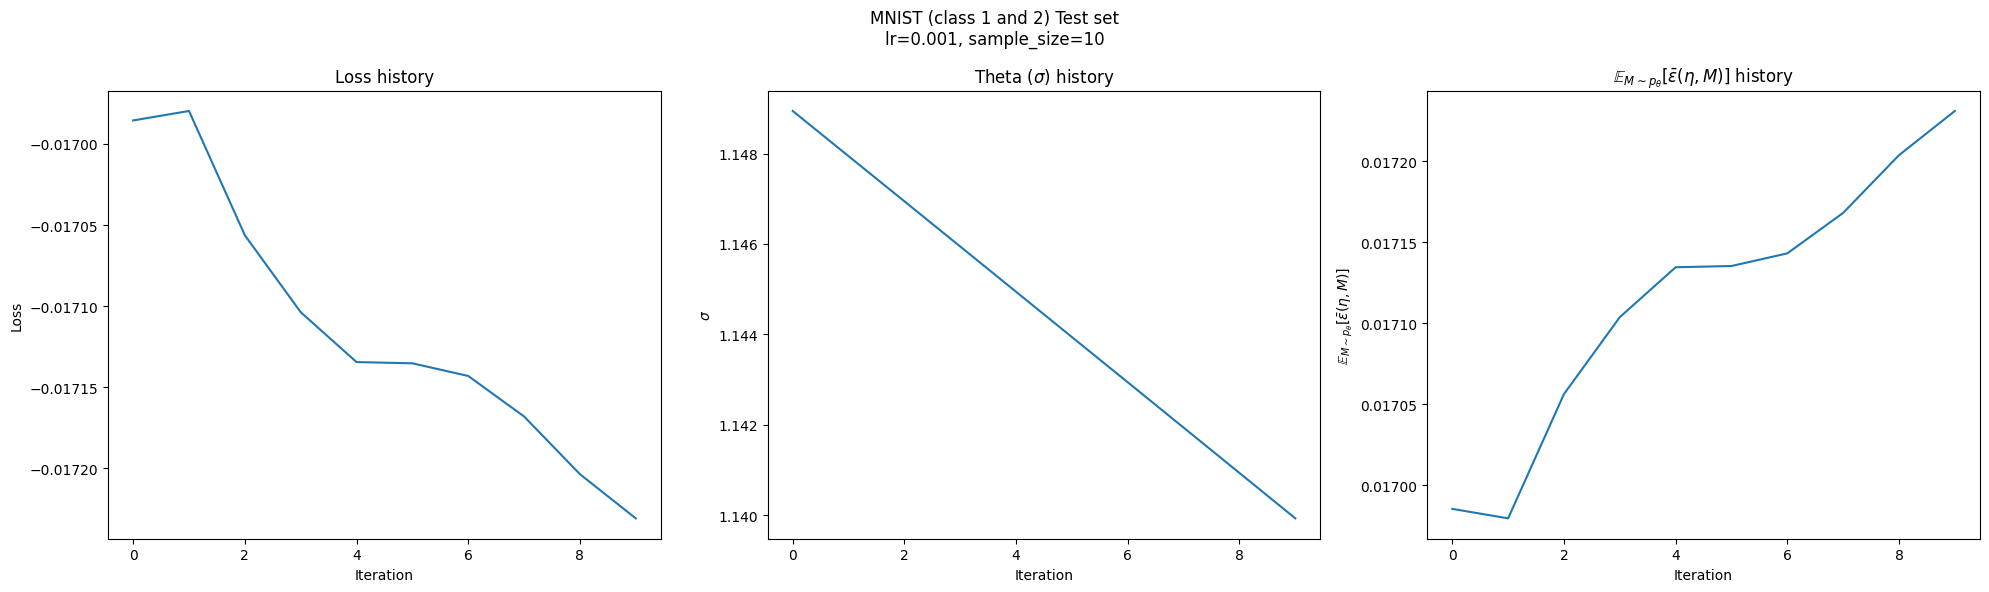

trial 1
Parameter containing:
tensor(1.8070, requires_grad=True)


  0%|          | 0/10 [03:09<?, ?it/s]


KeyboardInterrupt: 

In [9]:
sample_size = 10
lr = 0.001
epochs = 10

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history = train(sample_size=sample_size, lr=lr, epochs=epochs)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

trial 0
Parameter containing:
tensor(0.8529, requires_grad=True)


100%|██████████| 15/15 [1:59:06<00:00, 476.43s/it, Loss=-.0365, Theta=0.838, Epsilon=0.0365]


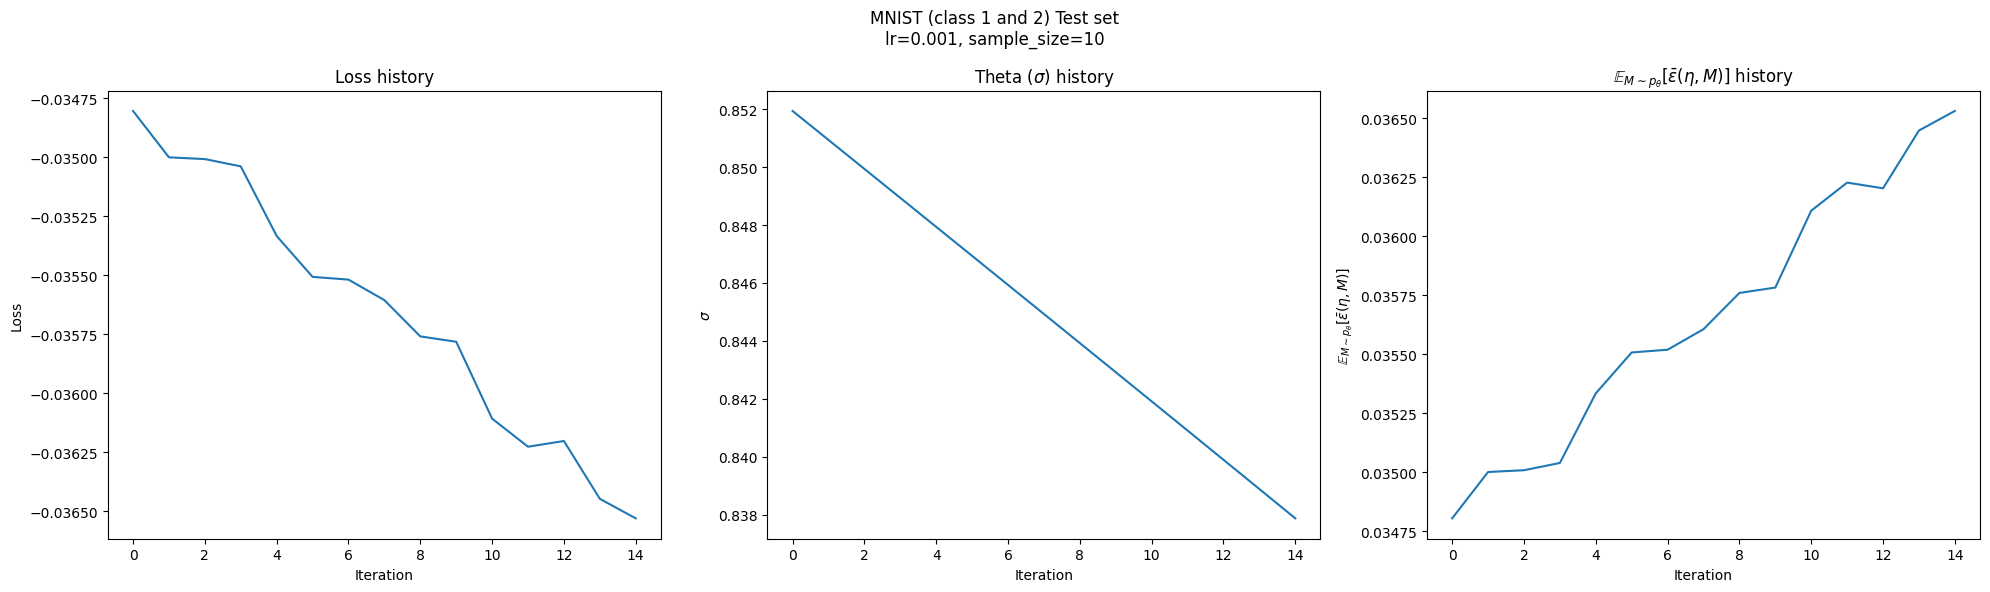

trial 1
Parameter containing:
tensor(0.2982, requires_grad=True)


100%|██████████| 15/15 [1:57:12<00:00, 468.85s/it, Loss=-.75, Theta=0.283, Epsilon=0.75]  


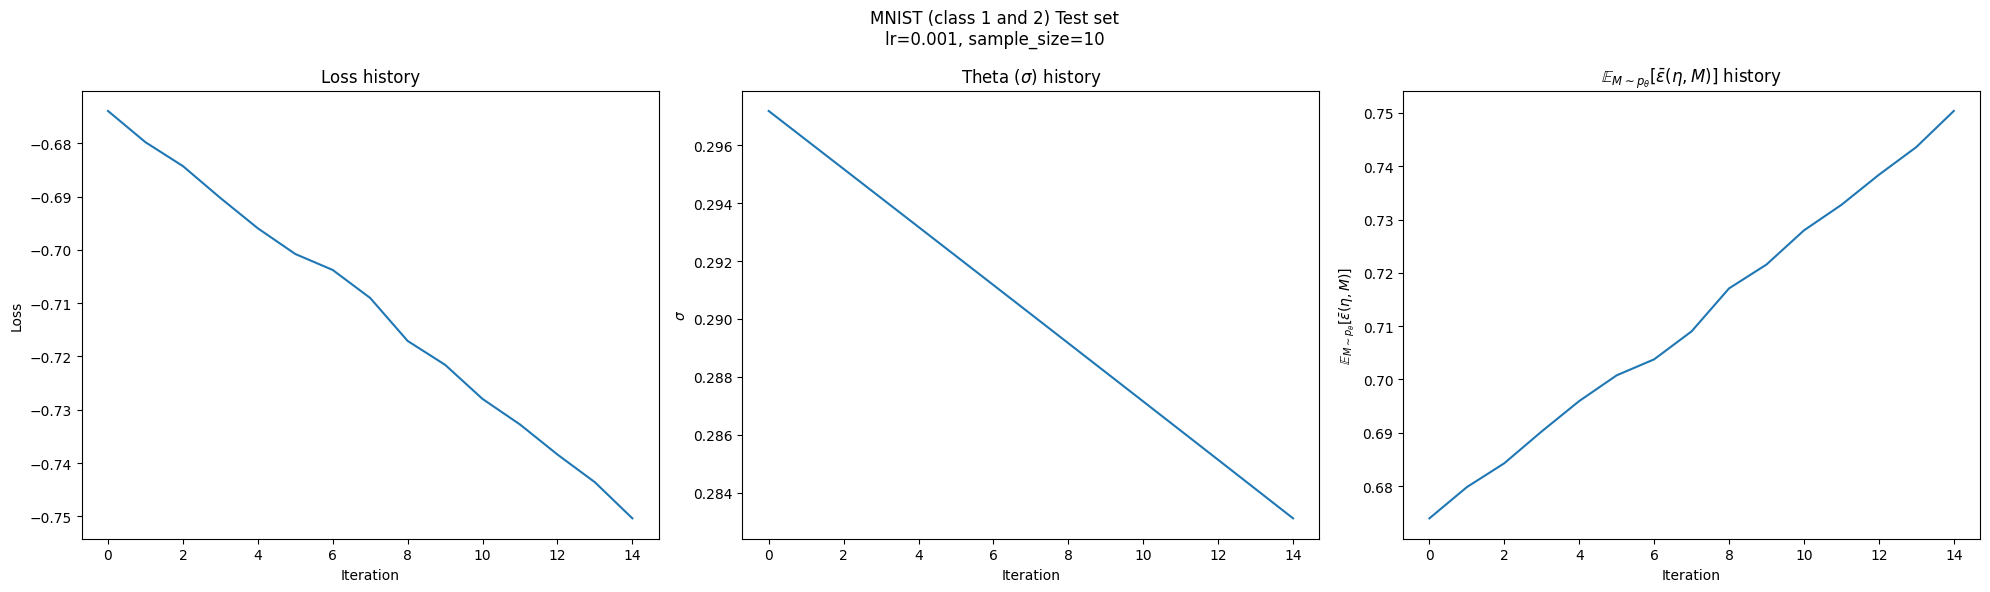

trial 2
Parameter containing:
tensor(0.3444, requires_grad=True)


100%|██████████| 15/15 [1:57:13<00:00, 468.89s/it, Loss=-.534, Theta=0.329, Epsilon=0.534]


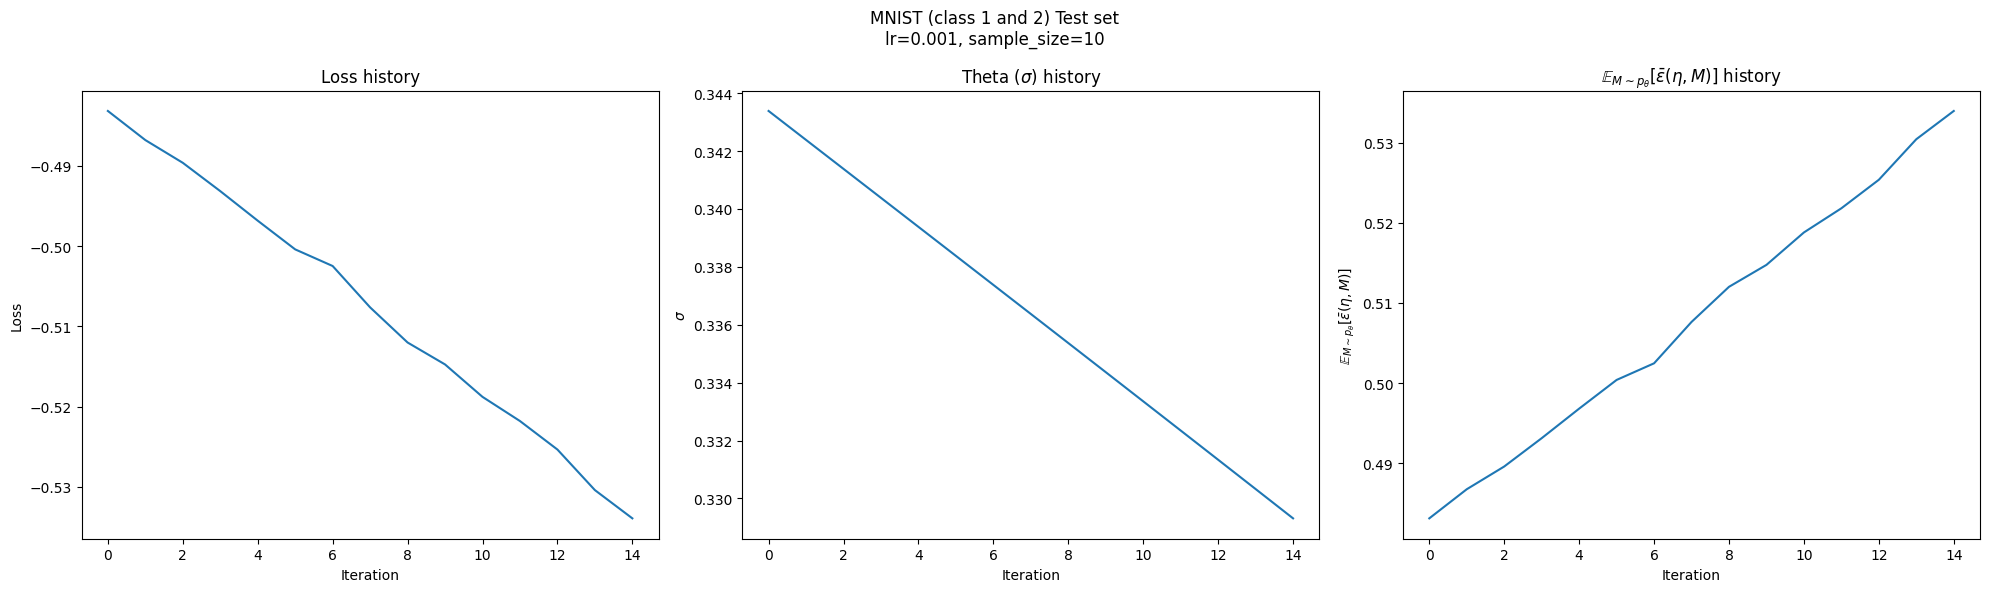

trial 3
Parameter containing:
tensor(0.8013, requires_grad=True)


100%|██████████| 15/15 [1:57:50<00:00, 471.35s/it, Loss=-.0445, Theta=0.786, Epsilon=0.0445]


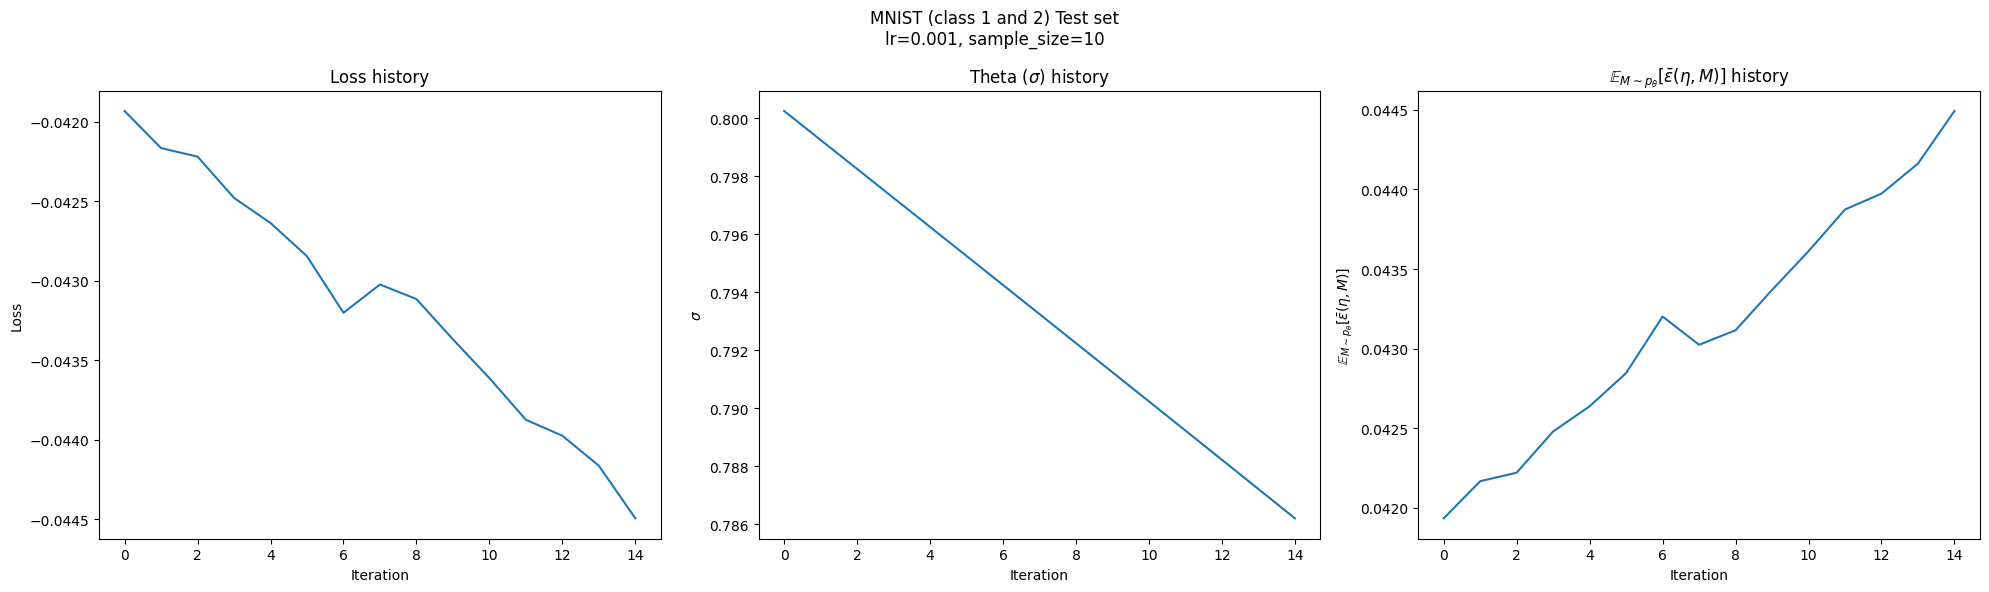

trial 4
Parameter containing:
tensor(1.0148, requires_grad=True)


100%|██████████| 15/15 [2:04:29<00:00, 497.95s/it, Loss=-.0227, Theta=1, Epsilon=0.0227]   


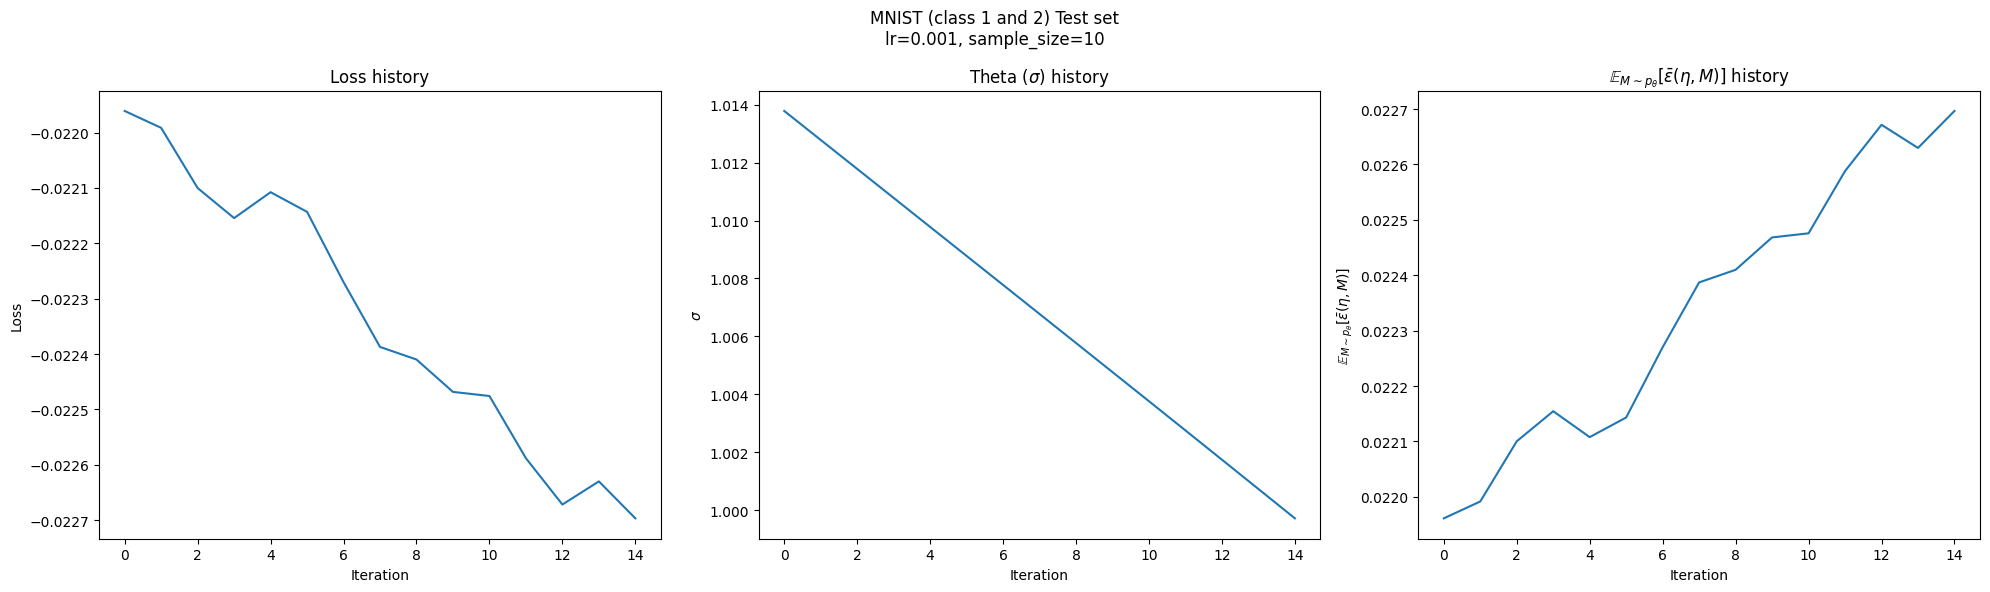

trial 5
Parameter containing:
tensor(0.3819, requires_grad=True)


100%|██████████| 15/15 [2:31:16<00:00, 605.11s/it, Loss=-.409, Theta=0.367, Epsilon=0.409] 


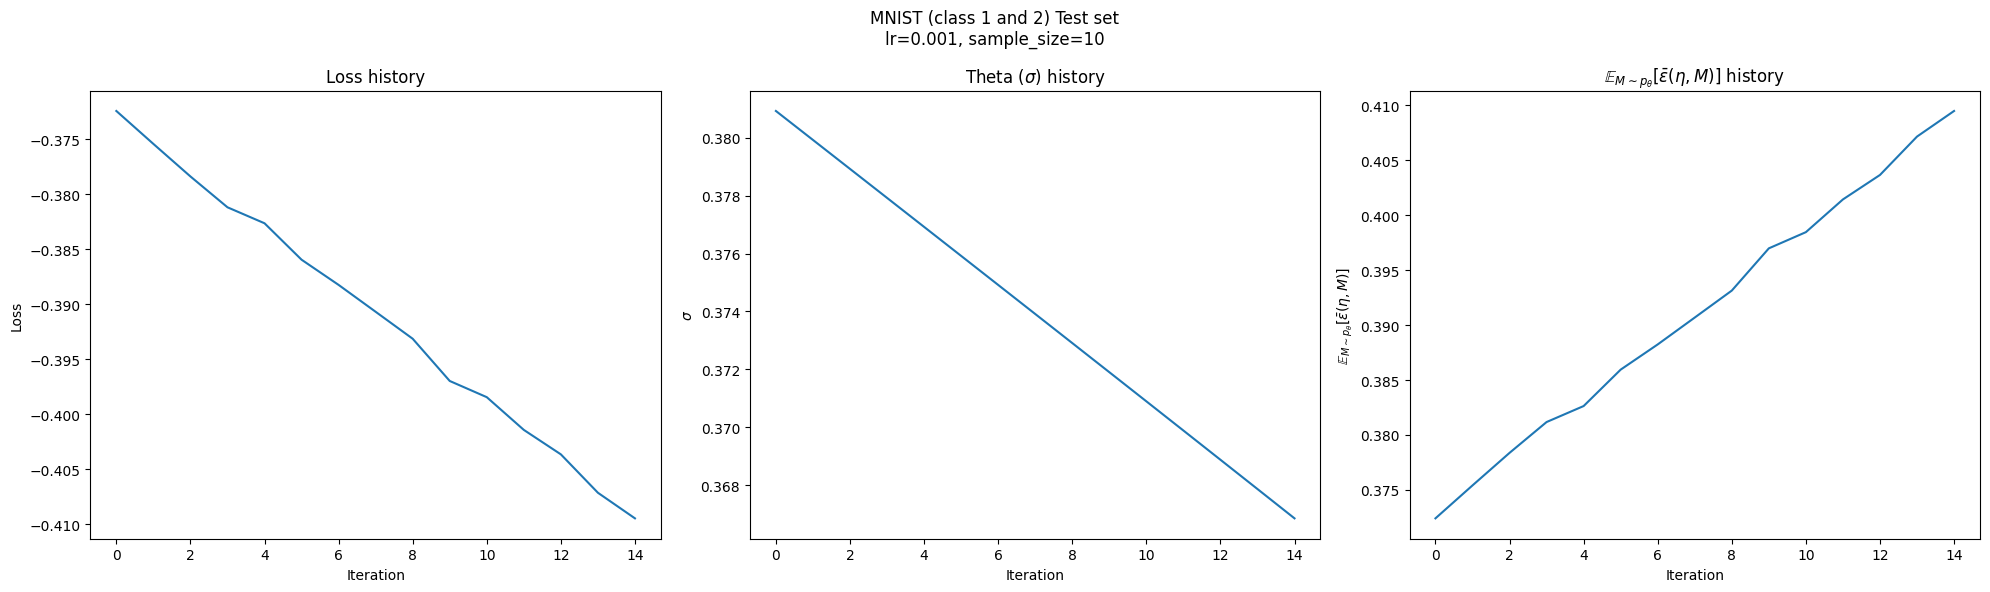

trial 6
Parameter containing:
tensor(1.6195, requires_grad=True)


100%|██████████| 15/15 [2:29:50<00:00, 599.36s/it, Loss=-.0108, Theta=1.6, Epsilon=0.0108]  


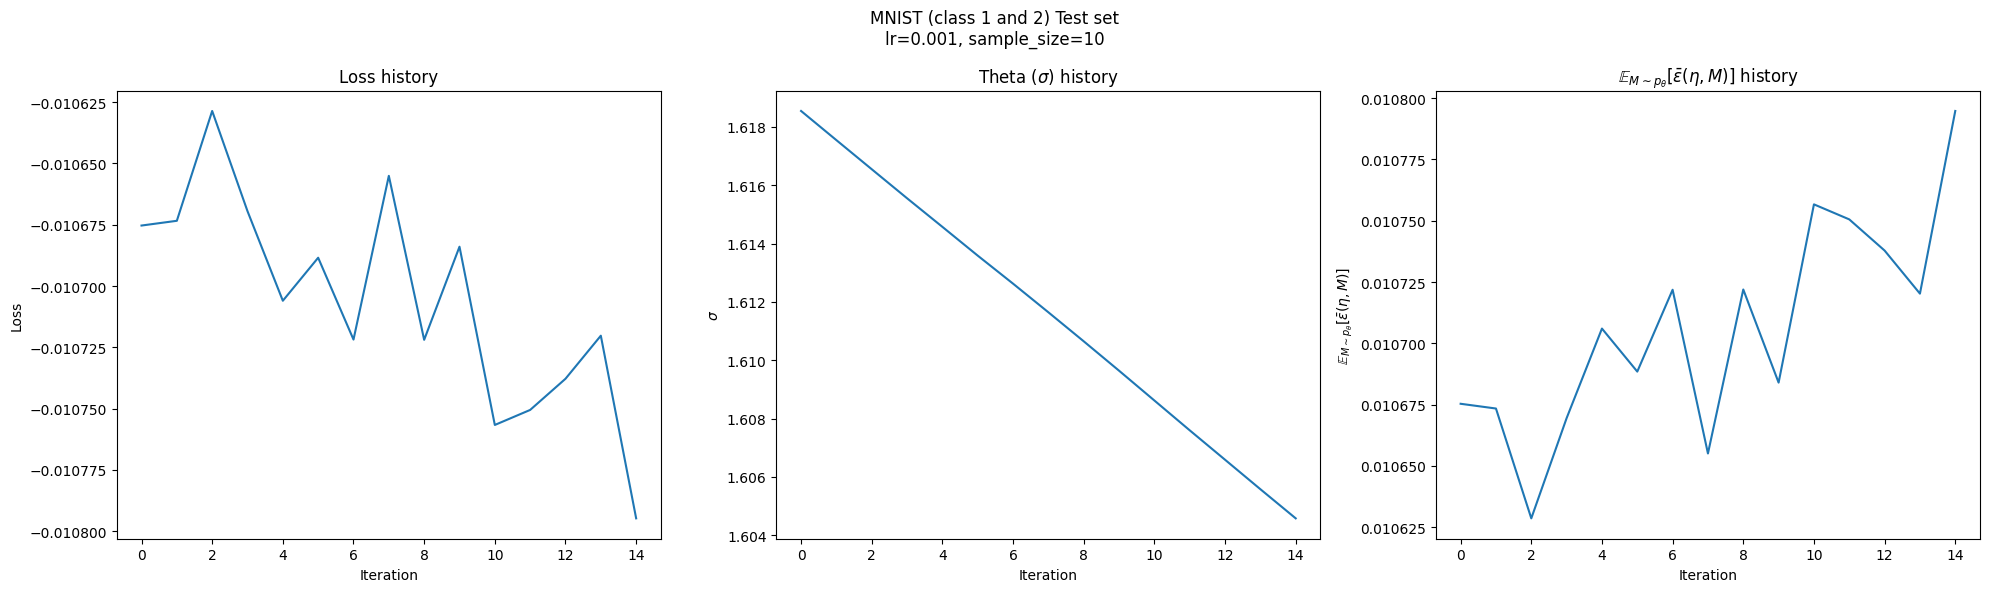

trial 7
Parameter containing:
tensor(1.0178, requires_grad=True)


100%|██████████| 15/15 [2:41:17<00:00, 645.19s/it, Loss=-.0225, Theta=1, Epsilon=0.0225]    


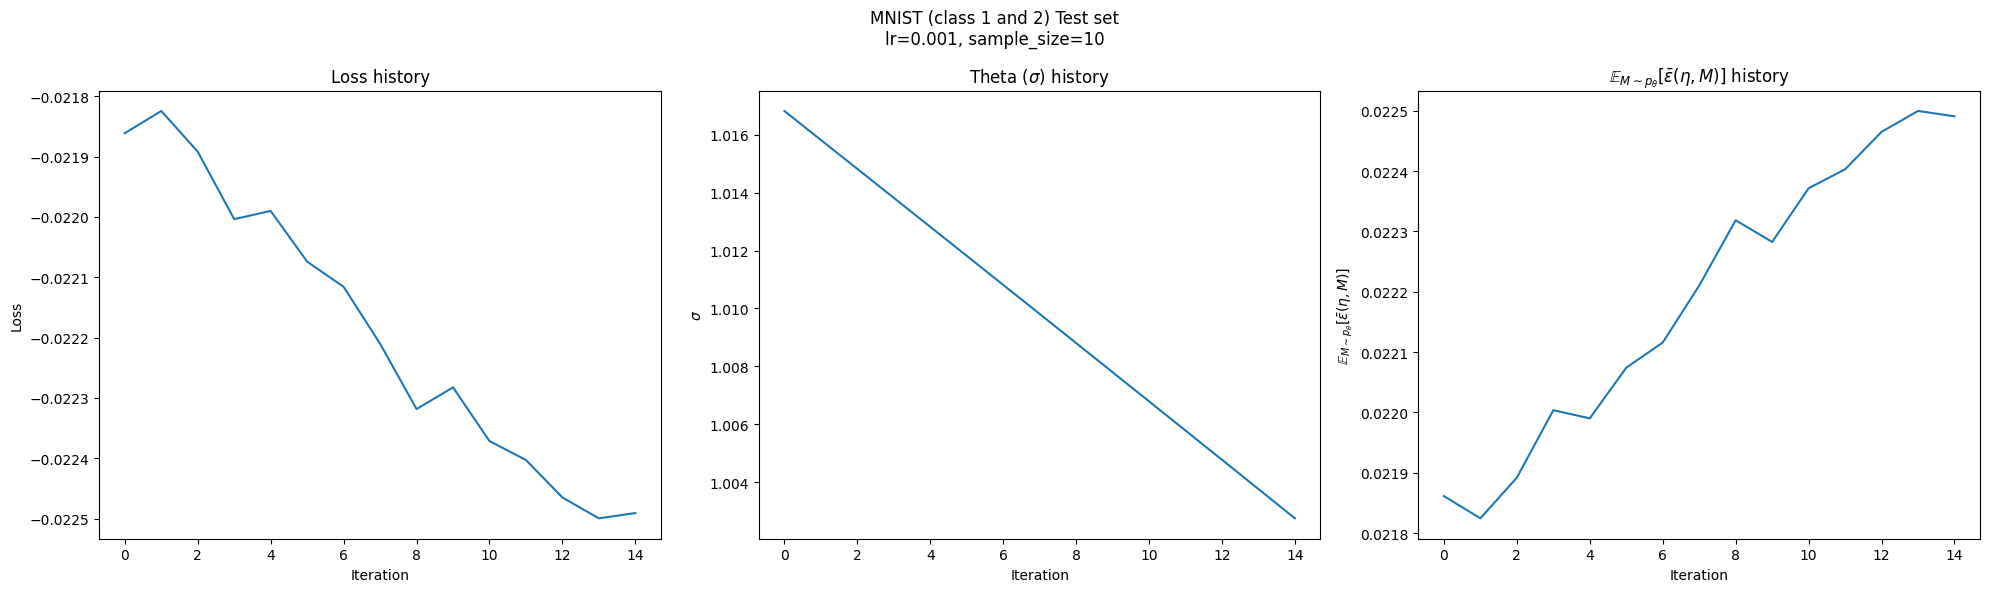

trial 8
Parameter containing:
tensor(0.7458, requires_grad=True)


100%|██████████| 15/15 [2:45:59<00:00, 663.97s/it, Loss=-.0556, Theta=0.731, Epsilon=0.0556] 


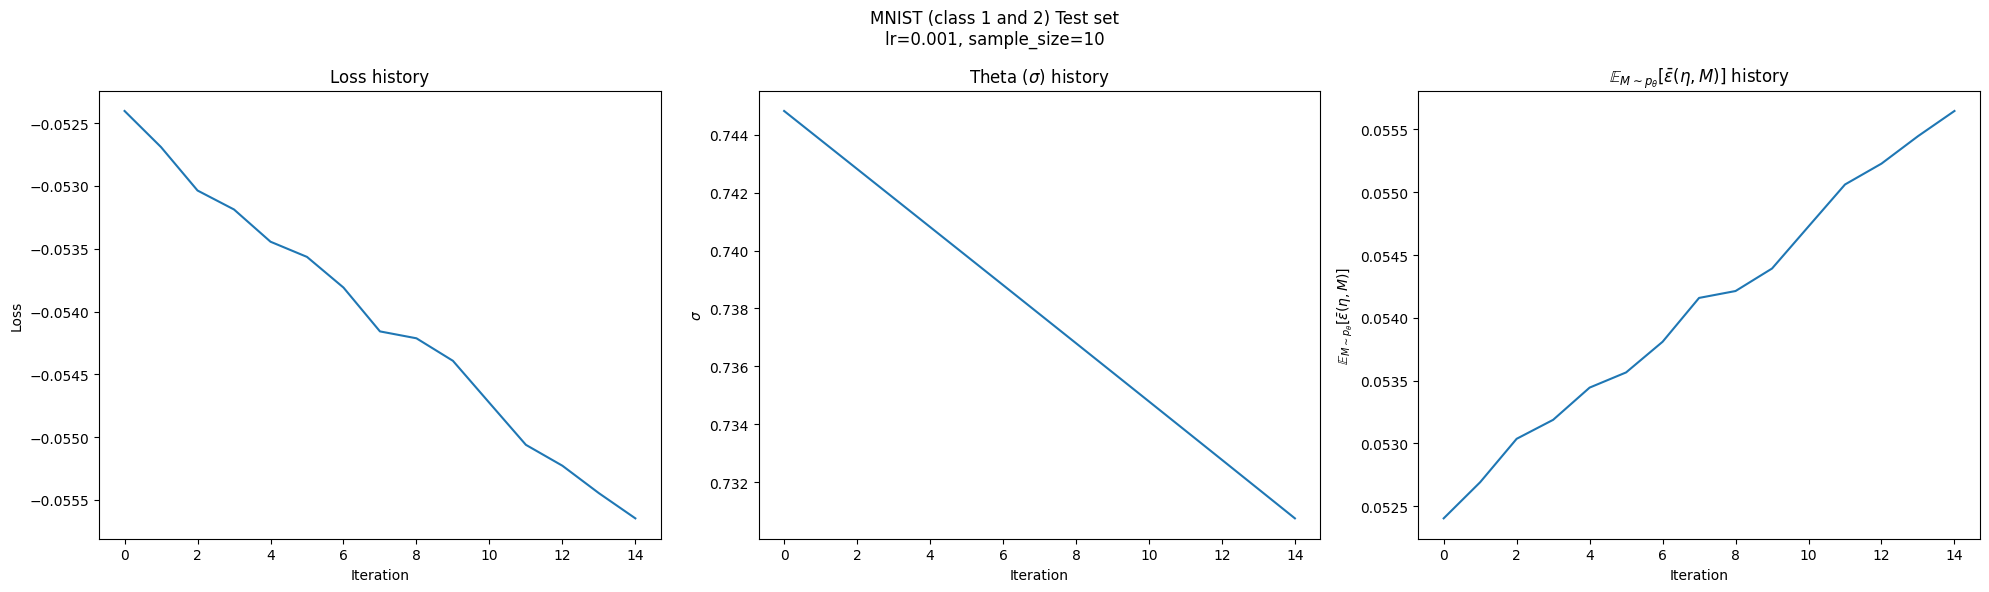

trial 9
Parameter containing:
tensor(1.1102, requires_grad=True)


 47%|████▋     | 7/15 [1:09:20<1:19:56, 599.61s/it, Loss=-.0184, Theta=1.1, Epsilon=0.0184]

In [11]:
sample_size = 10
lr = 0.001
epochs = 15

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history = train(sample_size=sample_size, lr=lr, epochs=epochs)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

In [ ]:
# 20%|██        | 3/15 [24:53<1:39:13, 496.16s/it, Loss=-.035, Theta=0.85, Epsilon=0.035]
# 27%|██▋       | 4/15 [33:04<1:30:37, 494.27s/it, Loss=-.035, Theta=0.849, Epsilon=0.035]